In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pyproj import Transformer

# celý DF/GeoDF vypisovat bez limitu
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# df_raw -> df_clean
df_raw = pd.read_excel('../data/czech/data_czech.xlsx')

df_clean = (
    df_raw
    .rename(columns={'University ↓ / Student →': 'destination'})
    .melt(
        id_vars='destination',
        var_name='origin',
        value_name='value'
    )
    .dropna(subset=['value'])
)
df_clean['origin']      = df_clean['origin'].str.strip()
df_clean['destination'] = df_clean['destination'].str.strip()
df_clean = df_clean[df_clean['origin'] != df_clean['destination']]
df_clean = df_clean[['origin','destination','value']]

df_clean.head()

,origin,destination,value
1,Hlavní město Praha,Jihomoravský kraj,986
2,Hlavní město Praha,Jihočeský kraj,572
3,Hlavní město Praha,Královéhradecký kraj,366
4,Hlavní město Praha,Liberecký kraj,324
5,Hlavní město Praha,Moravskoslezský kraj,232


In [3]:
# gdf_regions -> gdf_regions
gdf_regions = gpd.read_file('../data/czech/regions.gpkg')
gdf_regions = gdf_regions[['nazev','geometry']]
gdf_regions['centroid'] = gdf_regions.representative_point()

# Prepare transformation from WGS84 to the CRS of gdf
transformer = Transformer.from_crs("EPSG:4326", gdf_regions.crs, always_xy=True)

# Manually define centroid in WGS84 and transform it to target CRS
x, y = transformer.transform(14.9, 49.9)  # longitude, latitude
manual_centroids = {
    'Středočeský kraj': Point(x, y)
}

# Apply manual centroid if match is found
gdf_regions['centroid'] = gdf_regions.apply(
    lambda row: manual_centroids.get(row['nazev'], row['centroid']),
    axis=1
)

gdf_regions.head()

,nazev,geometry,centroid
0,Hlavní město Praha,"MULTIPOLYGON (((4644153.668 3017220.732, 46441...",POINT (4639467.91 3003862.303)
1,Jihočeský kraj,"MULTIPOLYGON (((4614559.886 2946839.972, 46145...",POINT (4654601.927 2896211.668)
2,Plzeňský kraj,"MULTIPOLYGON (((4557165.672 3003874.933, 45571...",POINT (4550638.407 2940237.936)
3,Karlovarský kraj,"MULTIPOLYGON (((4521107.248 3042368.86, 452110...",POINT (4521473.796 3010694.452)
4,Liberecký kraj,"MULTIPOLYGON (((4672911.633 3113397.259, 46729...",POINT (4673165.965 3082051.107)


In [4]:
# gdf_centroids pro merge
gdf_centroids = (
    gdf_regions
    .rename(columns={'nazev':'region'})
    [['region','centroid']]
)
gdf_centroids.head()

,region,centroid
0,Hlavní město Praha,POINT (4639467.91 3003862.303)
1,Jihočeský kraj,POINT (4654601.927 2896211.668)
2,Plzeňský kraj,POINT (4550638.407 2940237.936)
3,Karlovarský kraj,POINT (4521473.796 3010694.452)
4,Liberecký kraj,POINT (4673165.965 3082051.107)


In [5]:
# df_clean + gdf_centroids -> gdf_flows_base
df_merge = (
    df_clean
    # start
    .merge(
        gdf_centroids,
        left_on='origin', right_on='region', how='left'
    )
    .rename(columns={'centroid':'centroid_origin'})
    .drop(columns='region')
    # cíl
    .merge(
        gdf_centroids,
        left_on='destination', right_on='region', how='left'
    )
    .rename(columns={'centroid':'centroid_destination'})
    .drop(columns='region')
)

# vytvoření LineString
df_merge['geometry'] = df_merge.apply(
    lambda r: LineString([r.centroid_origin, r.centroid_destination]),
    axis=1
)

gdf_flows_base = gpd.GeoDataFrame(
    df_merge[['origin','destination','value','geometry']],
    geometry='geometry',
    crs=gdf_regions.crs
)

gdf_flows_base.head()


,origin,destination,value,geometry
0,Hlavní město Praha,Jihomoravský kraj,986,"LINESTRING (4639467.91 3003862.303, 4808459.22..."
1,Hlavní město Praha,Jihočeský kraj,572,"LINESTRING (4639467.91 3003862.303, 4654601.92..."
2,Hlavní město Praha,Královéhradecký kraj,366,"LINESTRING (4639467.91 3003862.303, 4726242.14..."
3,Hlavní město Praha,Liberecký kraj,324,"LINESTRING (4639467.91 3003862.303, 4673165.96..."
4,Hlavní město Praha,Moravskoslezský kraj,232,"LINESTRING (4639467.91 3003862.303, 4885595.65..."


In [6]:
# Textová klíčová dvojice
gdf_flows_total = gdf_flows_base.copy()
gdf_flows_total['pair'] = gdf_flows_total.apply(
    lambda r: tuple(sorted([r['origin'], r['destination']])),
    axis=1
)

# agregace
gdf_flows_total['value_total'] = (
    gdf_flows_total
    .groupby('pair')['value']
    .transform('sum')
)

# vyčištění
gdf_flows_total = gdf_flows_total.drop(columns='pair')

# zobrazíme
gdf_flows_total[['origin','destination','value','value_total','geometry']]


,origin,destination,value,value_total,geometry
0,Hlavní město Praha,Jihomoravský kraj,986,4226,"LINESTRING (4639467.91 3003862.303, 4808459.22..."
1,Hlavní město Praha,Jihočeský kraj,572,6410,"LINESTRING (4639467.91 3003862.303, 4654601.92..."
2,Hlavní město Praha,Královéhradecký kraj,366,5069,"LINESTRING (4639467.91 3003862.303, 4726242.14..."
3,Hlavní město Praha,Liberecký kraj,324,4359,"LINESTRING (4639467.91 3003862.303, 4673165.96..."
4,Hlavní město Praha,Moravskoslezský kraj,232,3681,"LINESTRING (4639467.91 3003862.303, 4885595.65..."
5,Hlavní město Praha,Olomoucký kraj,640,2696,"LINESTRING (4639467.91 3003862.303, 4821430.01..."
6,Hlavní město Praha,Pardubický kraj,262,3605,"LINESTRING (4639467.91 3003862.303, 4761771.75..."
7,Hlavní město Praha,Plzeňský kraj,657,4862,"LINESTRING (4639467.91 3003862.303, 4550638.40..."
8,Hlavní město Praha,Středočeský kraj,548,24853,"LINESTRING (4639467.91 3003862.303, 4672781.63..."
9,Hlavní město Praha,Kraj Vysočina,40,3200,"LINESTRING (4639467.91 3003862.303, 4724845.32..."


In [7]:
# Textová klíčová dvojice
gdf_flows_total = gdf_flows_base.copy()
gdf_flows_total['pair'] = gdf_flows_total.apply(
    lambda r: tuple(sorted([r['origin'], r['destination']])),
    axis=1
)

# agregace
gdf_flows_total['value_total'] = (
    gdf_flows_total
    .groupby('pair')['value']
    .transform('sum')
)

# vyčištění
gdf_flows_total = gdf_flows_total.drop(columns='pair')

# zobrazíme
gdf_flows_total[['origin','destination','value','value_total','geometry']]

,origin,destination,value,value_total,geometry
0,Hlavní město Praha,Jihomoravský kraj,986,4226,"LINESTRING (4639467.91 3003862.303, 4808459.22..."
1,Hlavní město Praha,Jihočeský kraj,572,6410,"LINESTRING (4639467.91 3003862.303, 4654601.92..."
2,Hlavní město Praha,Královéhradecký kraj,366,5069,"LINESTRING (4639467.91 3003862.303, 4726242.14..."
3,Hlavní město Praha,Liberecký kraj,324,4359,"LINESTRING (4639467.91 3003862.303, 4673165.96..."
4,Hlavní město Praha,Moravskoslezský kraj,232,3681,"LINESTRING (4639467.91 3003862.303, 4885595.65..."
5,Hlavní město Praha,Olomoucký kraj,640,2696,"LINESTRING (4639467.91 3003862.303, 4821430.01..."
6,Hlavní město Praha,Pardubický kraj,262,3605,"LINESTRING (4639467.91 3003862.303, 4761771.75..."
7,Hlavní město Praha,Plzeňský kraj,657,4862,"LINESTRING (4639467.91 3003862.303, 4550638.40..."
8,Hlavní město Praha,Středočeský kraj,548,24853,"LINESTRING (4639467.91 3003862.303, 4672781.63..."
9,Hlavní město Praha,Kraj Vysočina,40,3200,"LINESTRING (4639467.91 3003862.303, 4724845.32..."


In [8]:
# ─── Buňka: Výpočet podílu (%) pro každou hranu ──────────────────────────────────
# (spusť až poté, co máte gdf_flows_total)

# 1) Vytvoření kopie (nepřepisovat původní)
gdf_flows_pct = gdf_flows_total.copy()

# 2) Spočítat procentuální podíl: value / value_total * 100
gdf_flows_pct['pct'] = (
    gdf_flows_pct['value'] 
    / gdf_flows_pct['value_total'] 
    * 100
).round(2)   # zaokrouhlíme na 2 desetinná místa

# 3) Vybrat jen to, co chcete vidět
result = gdf_flows_pct[
    ['origin', 'destination', 'value', 'value_total', 'pct', 'geometry']
]

result['pct'] = pd.to_numeric(result['pct'], errors='coerce')

# 4) Zobrazit celý GeoDataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

result


,origin,destination,value,value_total,pct,geometry
0,Hlavní město Praha,Jihomoravský kraj,986,4226,23.33,"LINESTRING (4639467.91 3003862.303, 4808459.22..."
1,Hlavní město Praha,Jihočeský kraj,572,6410,8.92,"LINESTRING (4639467.91 3003862.303, 4654601.92..."
2,Hlavní město Praha,Královéhradecký kraj,366,5069,7.22,"LINESTRING (4639467.91 3003862.303, 4726242.14..."
3,Hlavní město Praha,Liberecký kraj,324,4359,7.43,"LINESTRING (4639467.91 3003862.303, 4673165.96..."
4,Hlavní město Praha,Moravskoslezský kraj,232,3681,6.30,"LINESTRING (4639467.91 3003862.303, 4885595.65..."
5,Hlavní město Praha,Olomoucký kraj,640,2696,23.74,"LINESTRING (4639467.91 3003862.303, 4821430.01..."
6,Hlavní město Praha,Pardubický kraj,262,3605,7.27,"LINESTRING (4639467.91 3003862.303, 4761771.75..."
7,Hlavní město Praha,Plzeňský kraj,657,4862,13.51,"LINESTRING (4639467.91 3003862.303, 4550638.40..."
8,Hlavní město Praha,Středočeský kraj,548,24853,2.20,"LINESTRING (4639467.91 3003862.303, 4672781.63..."
9,Hlavní město Praha,Kraj Vysočina,40,3200,1.25,"LINESTRING (4639467.91 3003862.303, 4724845.32..."


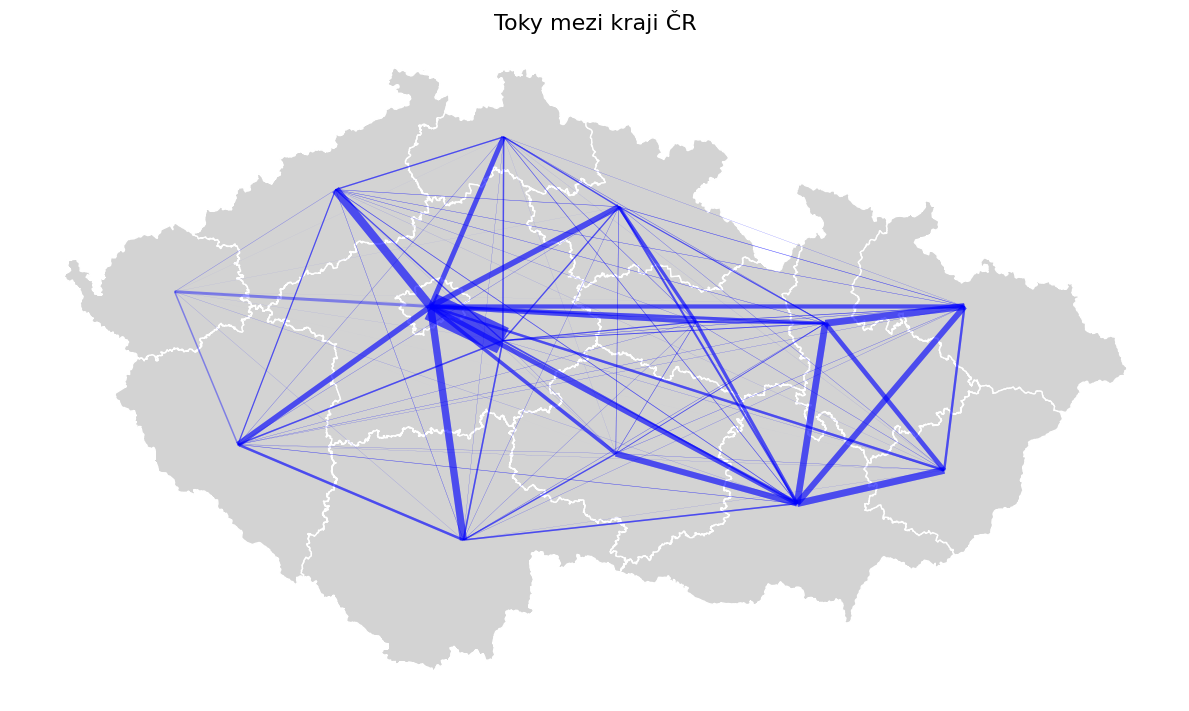

In [9]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot regions, flows, and centroids
gdf_regions.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_flows_total.plot(ax=ax, linewidth=gdf_flows_total['value_total']/gdf_flows_total['value_total'].max()*20, color='blue', alpha=0.4)

# Set plot title and remove axis
ax.set_title("Toky mezi kraji ČR", fontsize=16)
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [10]:
# Převod sloupce 'pct' na float
result['pct'] = result['pct'].astype(float)

# Set coordinate reference system (adjust if needed)
result = result.set_crs(epsg=3035)

# Export to GeoPackage
result.to_file('export_centroid_geometry.gpkg', driver='GPKG', layer='centroid_view')